In [1]:
import random
import numpy as np

In [2]:
def random_bases(length):
    return [random.randint(0, 1) for _ in range(length)]

def random_bits(length):
    return [random.randint(0, 1) for _ in range(length)]

def measure_bits(alice_bits, alice_bases, bob_bases, eve_present=False, lambda_eve=1.0):
    bob_bits = []
    
    for i in range(len(alice_bits)):
        if eve_present and random.random() < lambda_eve:
            eve_basis = random.randint(0, 1)
            eve_bit = alice_bits[i] if eve_basis == alice_bases[i] else random.randint(0, 1)
            bob_bit = eve_bit if bob_bases[i] == eve_basis else random.randint(0, 1)
        else:
            bob_bit = alice_bits[i] if bob_bases[i] == alice_bases[i] else random.randint(0, 1)
        
        bob_bits.append(bob_bit)
    
    return bob_bits

def sift_keys(alice_bits, bob_bits, alice_bases, bob_bases):
    sifted_alice = []
    sifted_bob = []
    for i in range(len(alice_bits)):
        if alice_bases[i] == bob_bases[i]:
            sifted_alice.append(alice_bits[i])
            sifted_bob.append(bob_bits[i])
    return sifted_alice, sifted_bob

def calculate_qber(alice_key, bob_key):
    if len(alice_key) == 0:
        return 0  # Avoid division by zero
    errors = sum([1 for i in range(len(alice_key)) if alice_key[i] != bob_key[i]])
    return errors / len(alice_key)

def bb84_simulation(num_bits, eve_present=False, lambda_eve=1.0):
    alice_bits = random_bits(num_bits)
    alice_bases = random_bases(num_bits)
    bob_bases = random_bases(num_bits)
    
    bob_bits = measure_bits(alice_bits, alice_bases, bob_bases, eve_present=eve_present, lambda_eve=lambda_eve)
    
    sifted_alice, sifted_bob = sift_keys(alice_bits, bob_bits, alice_bases, bob_bases)
    
    qber = calculate_qber(sifted_alice, sifted_bob)
    
    print("Sifted Key (Alice):", np.array(sifted_alice))
    print("Sifted Key (Bob):  ", np.array(sifted_bob))
    print(f"QBER: {qber * 100:.2f}%")
    
    return sifted_alice, sifted_bob, qber

In [3]:
# Test runs
print("** Simulation without Eve **")
bb84_simulation(100, eve_present=False)

print("\n** Simulation with Eve (λ = 1.0)**")
bb84_simulation(100, eve_present=True, lambda_eve=1.0)

print("\n** Simulation with Eve (λ = 0.5)**")
bb84_simulation(100, eve_present=True, lambda_eve=0.5)

** Simulation without Eve **
Sifted Key (Alice): [0 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1
 0 0 0 1 1 1 1 0 0 0]
Sifted Key (Bob):   [0 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1
 0 0 0 1 1 1 1 0 0 0]
QBER: 0.00%

** Simulation with Eve (λ = 1.0)**
Sifted Key (Alice): [0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0
 1 1 0 1 1 0 1 1 1 1 1 0 0]
Sifted Key (Bob):   [0 0 0 1 1 0 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 0
 0 1 0 1 1 0 0 1 0 1 1 1 0]
QBER: 34.00%

** Simulation with Eve (λ = 0.5)**
Sifted Key (Alice): [0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 0 1 0
 1 1 0 1 0 0 0 0]
Sifted Key (Bob):   [0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0
 1 1 0 1 0 1 0 0]
QBER: 13.33%


([0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0],
 [0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0],
 0.13333333333333333)

# 2. Attempt 2: SNR

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

In [5]:
# Function to generate random bits and bases
def random_bits_bases(length):
    return np.random.randint(0, 2, length), np.random.randint(0, 2, length)

# Function to apply SNR-based noise to the bits
def apply_snr_noise(bob_bits, snr_db):
    """Simulate bit-flip errors based on SNR (in dB)."""
    snr_linear = 10 ** (snr_db / 10)
    noise_variance = 1 / (2 * snr_linear)  # Assuming binary signaling
    noise = np.random.normal(0, np.sqrt(noise_variance), len(bob_bits))
    noisy_bits = np.where(noise > 0.5, 1 - bob_bits, bob_bits)  # Simulating bit flips based on noise
    return noisy_bits

# Function to simulate Bob's measurement
def measure_bits(alice_bits, alice_bases, bob_bases, eve_present=False, lambda_eve=1.0, snr_db=20):
    """Simulate Bob's measurement, including eavesdropping and channel noise."""
    # Start with Alice's bits as the base
    bob_bits = np.copy(alice_bits)

    # Eve's interference (optional)
    if eve_present:
        eve_bases = np.random.randint(0, 2, len(alice_bits))
        eve_bits = np.where(eve_bases == alice_bases, alice_bits, np.random.randint(0, 2, len(alice_bits)))
        bob_bits = np.where(bob_bases == eve_bases, eve_bits, np.random.randint(0, 2, len(alice_bits)))

    # Apply SNR-based channel noise
    bob_bits = apply_snr_noise(bob_bits, snr_db)
    
    # Measurement noise (classical error if Bob and Alice use different bases)
    bob_bits = np.where(bob_bases == alice_bases, bob_bits, np.random.randint(0, 2, len(alice_bits)))
    
    return bob_bits

# Function to perform key sifting (keeping bits with matching bases)
def sift_keys(alice_bits, bob_bits, alice_bases, bob_bases):
    match_bases = alice_bases == bob_bases
    sifted_alice = alice_bits[match_bases]
    sifted_bob = bob_bits[match_bases]
    return sifted_alice, sifted_bob

# Function to calculate Meta-QBER (using both sifted keys)
def calculate_meta_qber(sifted_alice, sifted_bob):
    errors = np.sum(sifted_alice != sifted_bob)
    return errors / len(sifted_alice) if len(sifted_alice) > 0 else 0

# Function to calculate Classical BER (without basis comparison)
def calculate_classical_ber(alice_bits, bob_bits):
    errors = np.sum(alice_bits != bob_bits)
    return errors / len(alice_bits)

# Function to simulate BB84 protocol with optional eavesdropping and noise
def bb84_simulation(num_bits, eve_present=False, lambda_eve=1.0, snr_db=20, spotting_fraction=0.1):
    # Generate random bits and bases for Alice and Bob
    alice_bits, alice_bases = random_bits_bases(num_bits)
    _, bob_bases = random_bits_bases(num_bits)

    # Bob measures Alice's bits (with or without Eve and noise)
    bob_bits = measure_bits(alice_bits, alice_bases, bob_bases, eve_present, lambda_eve, snr_db)

    # Sift keys based on matching bases
    sifted_alice, sifted_bob = sift_keys(alice_bits, bob_bits, alice_bases, bob_bases)

    # Spot a fraction of the sifted key to estimate QBER
    spot_size = int(len(sifted_alice) * spotting_fraction)
    spot_indices = np.random.choice(len(sifted_alice), spot_size, replace=False)
    spotted_alice, spotted_bob = sifted_alice[spot_indices], sifted_bob[spot_indices]
    
    # Calculate Meta-QBER (based on complete sifted keys)
    meta_qber = calculate_meta_qber(sifted_alice, sifted_bob)

    # Calculate Classical BER (before sifting)
    classical_ber = calculate_classical_ber(alice_bits, bob_bits)

    # Output results
    return {
        'sifted_alice': sifted_alice,
        'sifted_bob': sifted_bob,
        'spotted_alice': spotted_alice,
        'spotted_bob': spotted_bob,
        'meta_qber': meta_qber,
        'classical_ber': classical_ber,
        'key_length': len(sifted_alice)
    }

In [6]:
# Example simulation parameters
num_bits = 1000
eve_present = True
lambda_eve = 0.5
snr_db = 10  # SNR in dB
spotting_fraction = 0.1

# Run the simulation
results = bb84_simulation(num_bits, eve_present, lambda_eve, snr_db, spotting_fraction)

# Print the results
print(f"Sifted Key Length: {results['key_length']}")
print(f"Meta-QBER: {results['meta_qber'] * 100:.2f}%")
print(f"Classical BER: {results['classical_ber'] * 100:.2f}%")
print(f"Spotted Key Length: {len(results['spotted_alice'])}")

Sifted Key Length: 470
Meta-QBER: 25.11%
Classical BER: 38.30%
Spotted Key Length: 47


# 3. Attempt 3

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time

eve presence can be signalled by lambda alone.

In [8]:
# Function to generate random bits and bases
def random_bits_bases(length):
    return np.random.randint(0, 2, length), np.random.randint(0, 2, length)

# Function to apply SNR-based noise to the bits
def apply_snr_noise(bob_bits, snr_db):    # AWGN
    """Simulate bit-flip errors based on SNR (in dB)."""
    snr_linear = 10 ** (snr_db / 10)
    noise_variance = 1 / (2 * snr_linear)  # Should this be changed to the accurate formula? snr2ber(snr_db) could be used here
    noise = np.random.normal(0, np.sqrt(noise_variance), len(bob_bits))
    noisy_bits = np.where(noise > 0.5, 1 - bob_bits, bob_bits)  # Simulating bit flips based on noise
    return noisy_bits

# Function to simulate Bob's measurement
def measure_bits(alice_bits, alice_bases, bob_bases, eve_present=False, lambda_eve=1.0, snr_db=20):
    """Simulate Bob's measurement, including eavesdropping and channel noise."""
    bob_bits = np.copy(alice_bits)

    # Eve's interference (optional)
    if eve_present:
        eve_bases = np.random.randint(0, 2, len(alice_bits))
        eve_bits = np.where(eve_bases == alice_bases, alice_bits, np.random.randint(0, 2, len(alice_bits)))
        bob_bits = np.where(bob_bases == eve_bases, eve_bits, np.random.randint(0, 2, len(alice_bits)))

    # Apply SNR-based channel noise
    bob_bits = apply_snr_noise(bob_bits, snr_db)
    
    # Measurement noise (classical error if Bob and Alice use different bases)
    bob_bits = np.where(bob_bases == alice_bases, bob_bits, np.random.randint(0, 2, len(alice_bits)))
    
    return bob_bits

# Function to perform key sifting (keeping bits with matching bases)
def sift_keys(alice_bits, bob_bits, alice_bases, bob_bases):
    match_bases = alice_bases == bob_bases
    sifted_alice = alice_bits[match_bases]
    sifted_bob = bob_bits[match_bases]
    return sifted_alice, sifted_bob

# Function to calculate Meta-QBER (using both sifted keys)
def calculate_meta_qber(sifted_alice, sifted_bob):
    errors = np.sum(sifted_alice != sifted_bob)
    return errors / len(sifted_alice) if len(sifted_alice) > 0 else 0

# Function to calculate QBER using spotted bits
def calculate_spot_qber(spotted_alice, spotted_bob):
    errors = np.sum(spotted_alice != spotted_bob)
    return errors / len(spotted_alice) if len(spotted_alice) > 0 else 0

# Function to calculate Classical BER (without basis comparison)
def calculate_classical_ber(alice_bits, bob_bits):
    errors = np.sum(alice_bits != bob_bits)
    return errors / len(alice_bits)

In [9]:
# Function to simulate BB84 protocol with optional eavesdropping and noise
def bb84_simulation(num_bits, eve_present=False, lambda_eve=1.0, snr_db=20, spotting_fraction=0.1):
    # Generate random bits and bases for Alice and Bob
    alice_bits, alice_bases = random_bits_bases(num_bits)
    _, bob_bases = random_bits_bases(num_bits)

    # Bob measures Alice's bits (with or without Eve and noise)
    bob_bits = measure_bits(alice_bits, alice_bases, bob_bases, eve_present, lambda_eve, snr_db)

    # Sift keys based on matching bases
    sifted_alice, sifted_bob = sift_keys(alice_bits, bob_bits, alice_bases, bob_bases)

    # Spot a fraction of the sifted key to estimate QBER
    spot_size = int(len(sifted_alice) * spotting_fraction)
    spot_indices = np.random.choice(len(sifted_alice), spot_size, replace=False)
    spotted_alice, spotted_bob = sifted_alice[spot_indices], sifted_bob[spot_indices]
    
    # Calculate Meta-QBER (based on complete sifted keys)
    meta_qber = calculate_meta_qber(sifted_alice, sifted_bob)

    # Calculate Spotted QBER (using spotted bits only)
    spot_qber = calculate_spot_qber(spotted_alice, spotted_bob)

    # Calculate Classical BER (before sifting)
    classical_ber = calculate_classical_ber(alice_bits, bob_bits)

    return {
        'sifted_alice': sifted_alice,
        'sifted_bob': sifted_bob,
        'meta_qber': meta_qber,
        'spot_qber': spot_qber,
        'classical_ber': classical_ber,
        'key_length': len(sifted_alice)
    }

In [10]:
# Simulate over a range of SNR values
def run_simulation_over_snr(snr_range, num_iterations=10, num_bits=1000, eve_present=False, lambda_eve=0.5, spotting_fraction=0.1):
    avg_meta_qber = []
    avg_spot_qber = []
    avg_classical_ber = []
    avg_key_length = []
    avg_secure_key_rate = []
    
    for snr_db in snr_range:
        meta_qber_sum = 0
        spot_qber_sum = 0
        classical_ber_sum = 0
        key_length_sum = 0
        secure_key_rate_sum = 0
        start_time = time.time()

        for _ in range(num_iterations):
            results = bb84_simulation(num_bits, eve_present, lambda_eve, snr_db, spotting_fraction)
            meta_qber_sum += results['meta_qber']
            spot_qber_sum += results['spot_qber']
            classical_ber_sum += results['classical_ber']
            key_length_sum += results['key_length']
            secure_key_rate_sum += (results['key_length'] - results['key_length'] * results['spot_qber'])

        avg_meta_qber.append(meta_qber_sum / num_iterations)
        avg_spot_qber.append(spot_qber_sum / num_iterations)
        avg_classical_ber.append(classical_ber_sum / num_iterations)
        avg_key_length.append(key_length_sum / num_iterations)
        avg_secure_key_rate.append(secure_key_rate_sum / num_iterations)
    
    return avg_meta_qber, avg_spot_qber, avg_classical_ber, avg_key_length, avg_secure_key_rate

In [11]:
# Plot the results
def plot_results(snr_range, meta_qber, spot_qber, classical_ber, key_length, secure_key_rate):
    plt.figure(figsize=(14, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(snr_range, meta_qber, 'bo-', markersize = 3, label="Meta QBER")
    plt.plot(snr_range, spot_qber, 'rs-', markersize = 3, label="Spot QBER")
    plt.axhline(y = 0.25, linewidth = 0.8, alpha = 0.3, linestyle = '--')
    plt.xlabel("SNR (dB)")
    plt.ylabel("QBER")
    plt.title("QBER vs. SNR")
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(snr_range, classical_ber, 'bo-', markersize = 3, label="Classical BER")
    plt.axhline(y = 0.25, linewidth = 0.8, alpha = 0.3, linestyle = '--')
    plt.xlabel("SNR (dB)")
    plt.ylabel("Classical BER")
    plt.title("Classical BER vs. SNR")
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(snr_range, key_length, 'bo-', markersize = 3, label="Sifted Key Length")
    plt.axhline(y = 0.25, linewidth = 0.8, alpha = 0.3, linestyle = '--')
    plt.xlabel("SNR (dB)")
    plt.ylabel("Key Length")
    plt.title("Sifted Key Length vs. SNR")
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(snr_range, secure_key_rate, 'bo-', markersize = 3, label="Secure Key Rate")
    plt.xlabel("SNR (dB)")
    plt.ylabel("Secure Key Rate")
    plt.title("Secure Key Rate vs. SNR")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [20]:
%%time
# Parameters
snr_range = np.arange(-1, 12.5, 0.25)
num_keys = 100
monte_carlo_sim = 1000
desired_key_length = 256

key_length = 3*desired_key_length
spot_fraction = 1/3    # one third of the sifted key

# Run the simulation
meta_qber = np.zeros(len(snr_range))
spot_qber = np.zeros(len(snr_range))
classical_ber = np.zeros(len(snr_range))
key_length = np.zeros(len(snr_range))
secure_key_rate = np.zeros(len(snr_range))

for i in range(monte_carlo_sim):
    meta_qber, spot_qber, classical_ber, key_length, secure_key_rate = run_simulation_over_snr(snr_range, num_keys)

CPU times: user 25min 56s, sys: 171 ms, total: 25min 56s
Wall time: 25min 57s


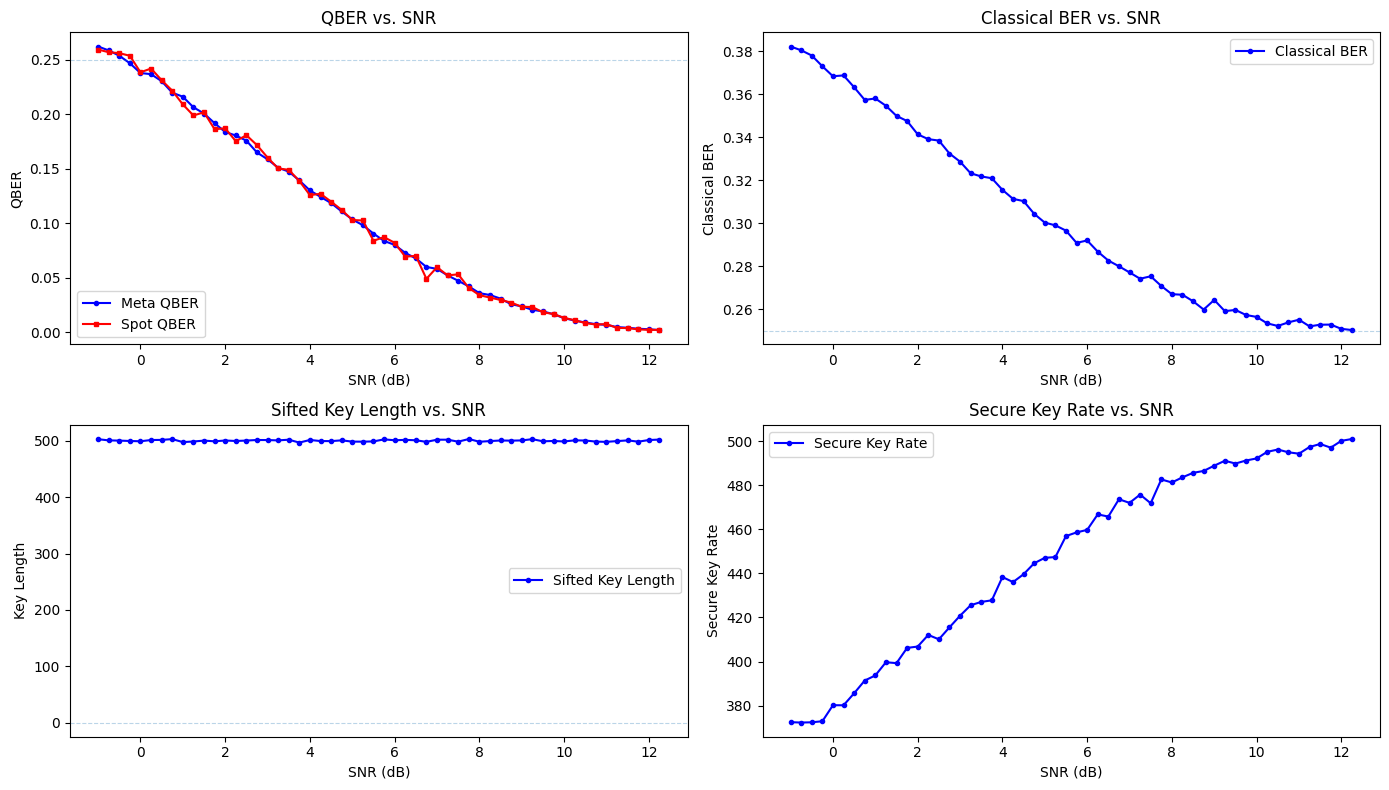

In [21]:
# Plot the results
plot_results(snr_range, meta_qber, spot_qber, classical_ber, key_length, secure_key_rate)

# 4. Attempt 4: MC+Seaborn+Error Bar

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [15]:
# Function to generate random bits and bases
def random_bits_bases(length):
    return np.random.randint(0, 2, length), np.random.randint(0, 2, length)

# Function to apply SNR-based noise to the bits
def apply_snr_noise(bob_bits, snr_db):
    """Simulate bit-flip errors based on SNR (in dB)."""
    snr_linear = 10 ** (snr_db / 10)
    noise_variance = 1 / (2 * snr_linear)  # Assuming binary signaling
    noise = np.random.normal(0, np.sqrt(noise_variance), len(bob_bits))
    noisy_bits = np.where(noise > 0.5, 1 - bob_bits, bob_bits)  # Simulating bit flips based on noise
    return noisy_bits

# Function to simulate Bob's measurement
def measure_bits(alice_bits, alice_bases, bob_bases, eve_present=False, lambda_eve=1.0, snr_db=20):
    """Simulate Bob's measurement, including eavesdropping and channel noise."""
    bob_bits = np.copy(alice_bits)

    # Eve's interference (optional)
    if eve_present:
        eve_bases = np.random.randint(0, 2, len(alice_bits))
        eve_bits = np.where(eve_bases == alice_bases, alice_bits, np.random.randint(0, 2, len(alice_bits)))
        bob_bits = np.where(bob_bases == eve_bases, eve_bits, np.random.randint(0, 2, len(alice_bits)))

    # Apply SNR-based channel noise
    bob_bits = apply_snr_noise(bob_bits, snr_db)
    
    # Measurement noise (classical error if Bob and Alice use different bases)
    bob_bits = np.where(bob_bases == alice_bases, bob_bits, np.random.randint(0, 2, len(alice_bits)))
    
    return bob_bits

In [16]:
# Function to perform key sifting (keeping bits with matching bases)
def sift_keys(alice_bits, bob_bits, alice_bases, bob_bases):
    match_bases = alice_bases == bob_bases
    sifted_alice = alice_bits[match_bases]
    sifted_bob = bob_bits[match_bases]
    return sifted_alice, sifted_bob

# Function to calculate Meta-QBER (using both sifted keys)
def calculate_meta_qber(sifted_alice, sifted_bob):
    errors = np.sum(sifted_alice != sifted_bob)
    return errors / len(sifted_alice) if len(sifted_alice) > 0 else 0

# Function to calculate QBER using spotted bits
def calculate_spot_qber(spotted_alice, spotted_bob):
    errors = np.sum(spotted_alice != spotted_bob)
    return errors / len(spotted_alice) if len(spotted_alice) > 0 else 0

# Function to calculate Classical BER (without basis comparison)
def calculate_classical_ber(alice_bits, bob_bits):
    errors = np.sum(alice_bits != bob_bits)
    return errors / len(alice_bits)

In [17]:
# Function to simulate BB84 protocol with optional eavesdropping and noise
def bb84_simulation(num_bits, eve_present=False, lambda_eve=1.0, snr_db=20, spotting_fraction=0.1):
    # Generate random bits and bases for Alice and Bob
    alice_bits, alice_bases = random_bits_bases(num_bits)
    _, bob_bases = random_bits_bases(num_bits)

    # Bob measures Alice's bits (with or without Eve and noise)
    bob_bits = measure_bits(alice_bits, alice_bases, bob_bases, eve_present, lambda_eve, snr_db)

    # Sift keys based on matching bases
    sifted_alice, sifted_bob = sift_keys(alice_bits, bob_bits, alice_bases, bob_bases)

    # Spot a fraction of the sifted key to estimate QBER
    spot_size = int(len(sifted_alice) * spotting_fraction)
    spot_indices = np.random.choice(len(sifted_alice), spot_size, replace=False)
    spotted_alice, spotted_bob = sifted_alice[spot_indices], sifted_bob[spot_indices]
    
    # Calculate Meta-QBER (based on complete sifted keys)
    meta_qber = calculate_meta_qber(sifted_alice, sifted_bob)

    # Calculate Spotted QBER (using spotted bits only)
    spot_qber = calculate_spot_qber(spotted_alice, spotted_bob)

    # Calculate Classical BER (before sifting)
    classical_ber = calculate_classical_ber(alice_bits, bob_bits)

    return {
        'sifted_alice': sifted_alice,
        'sifted_bob': sifted_bob,
        'meta_qber': meta_qber,
        'spot_qber': spot_qber,
        'classical_ber': classical_ber,
        'key_length': len(sifted_alice)
    }

In [18]:
# Simulate over a range of SNR values
def run_monte_carlo_simulation(snr_range, num_simulations=500, num_keys_per_sim=1000, eve_present=False, lambda_eve=0.5, spotting_fraction=0.1):
    avg_meta_qber = []
    avg_spot_qber = []
    avg_classical_ber = []
    avg_key_length = []
    avg_secure_key_rate = []
    
    for snr_db in snr_range:
        meta_qber_sum = 0
        spot_qber_sum = 0
        classical_ber_sum = 0
        key_length_sum = 0
        secure_key_rate_sum = 0

        for _ in range(num_simulations):
            results = bb84_simulation(num_keys_per_sim, eve_present, lambda_eve, snr_db, spotting_fraction)
            meta_qber_sum += results['meta_qber']
            spot_qber_sum += results['spot_qber']
            classical_ber_sum += results['classical_ber']
            key_length_sum += results['key_length']
            secure_key_rate_sum += (results['key_length'] - results['key_length'] * results['spot_qber'])

        avg_meta_qber.append(meta_qber_sum / num_simulations)
        avg_spot_qber.append(spot_qber_sum / num_simulations)
        avg_classical_ber.append(classical_ber_sum / num_simulations)
        avg_key_length.append(key_length_sum / num_simulations)
        avg_secure_key_rate.append(secure_key_rate_sum / num_simulations)
    
    return avg_meta_qber, avg_spot_qber, avg_classical_ber, avg_key_length, avg_secure_key_rate

In [19]:
# Plot the results using Seaborn
def plot_results(snr_range, meta_qber, spot_qber, classical_ber, key_length, secure_key_rate):
    sns.set(style="whitegrid")
    
    plt.figure(figsize=(14, 

SyntaxError: incomplete input (4279139599.py, line 5)